In [13]:
# resnet18_training.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Paths
DATASET_DIR = "../data/processed"
train_dir = os.path.join(DATASET_DIR, "train")
val_dir = os.path.join(DATASET_DIR, "val")
test_dir = os.path.join(DATASET_DIR, "test")

In [16]:
# === Transforms ===
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [17]:
# Load datasets
datasets_dict = {
    'train': datasets.ImageFolder(train_dir, transform=transform),
    'val': datasets.ImageFolder(val_dir, transform=transform),
    'test': datasets.ImageFolder(test_dir, transform=transform)
}

In [18]:
# DataLoaders
dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=32, shuffle=(x == 'train'), num_workers=4, prefetch_factor=4)
    for x in ['train', 'val', 'test']
}

class_names = datasets_dict['train'].classes
num_classes = len(class_names)

In [19]:
# === NEW: Compute class weights ===
train_labels = [label for _, label in datasets_dict['train']]
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [20]:
# === Load and Modify Pretrained Model ===
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# ✅ Unfreeze layer3 + layer4 + fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [21]:
# ✅ Weighted Loss + Label Smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.0)

# ✅ Add weight decay (L2 regularization)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [22]:
# TensorBoard writer
writer = SummaryWriter(log_dir="runs/resnet18_experiment_v4")

In [23]:
# === Training Function with Early Stopping ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_dict[phase])
            epoch_acc = running_corrects.double() / len(datasets_dict[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)

            if phase == 'train':
                train_loss_hist.append(epoch_loss)
                train_acc_hist.append(epoch_acc.item())
            else:
                val_loss_hist.append(epoch_loss)
                val_acc_hist.append(epoch_acc.item())
                scheduler.step(epoch_loss)

                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), "../model/dermai_model_v3.pth")
                    patience_counter = 0  # Reset patience if improved
                    print("✅ Best model updated.")
                else:
                    patience_counter += 1
                    print(f"⚠️ Patience: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print("⏹️ Early stopping triggered.")
                        return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

    print("\n✅ Training complete. Best validation loss: {:.4f}".format(best_val_loss))
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist


In [24]:
# === Train ===
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=20, patience=5
)


Epoch 1/20
--------------------


100%|██████████| 515/515 [08:44<00:00,  1.02s/batch]


Train Loss: 1.7928 Acc: 0.4263


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 1.4636 Acc: 0.5157
✅ Best model updated.

Epoch 2/20
--------------------


100%|██████████| 515/515 [08:35<00:00,  1.00s/batch]


Train Loss: 1.2067 Acc: 0.5514


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 1.2086 Acc: 0.5921
✅ Best model updated.

Epoch 3/20
--------------------


100%|██████████| 515/515 [08:41<00:00,  1.01s/batch]


Train Loss: 0.9826 Acc: 0.6047


100%|██████████| 110/110 [01:26<00:00,  1.27batch/s]


Val Loss: 1.2212 Acc: 0.5884
⚠️ Patience: 1/5

Epoch 4/20
--------------------


100%|██████████| 515/515 [08:40<00:00,  1.01s/batch]


Train Loss: 0.8797 Acc: 0.6333


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 1.1394 Acc: 0.6172
✅ Best model updated.

Epoch 5/20
--------------------


100%|██████████| 515/515 [08:32<00:00,  1.00batch/s]


Train Loss: 0.7919 Acc: 0.6632


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 1.1741 Acc: 0.6375
⚠️ Patience: 1/5

Epoch 6/20
--------------------


100%|██████████| 515/515 [08:44<00:00,  1.02s/batch]


Train Loss: 0.7483 Acc: 0.6753


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 1.1295 Acc: 0.6315
✅ Best model updated.

Epoch 7/20
--------------------


100%|██████████| 515/515 [08:36<00:00,  1.00s/batch]


Train Loss: 0.6565 Acc: 0.7040


100%|██████████| 110/110 [01:26<00:00,  1.27batch/s]


Val Loss: 1.1251 Acc: 0.6389
✅ Best model updated.

Epoch 8/20
--------------------


100%|██████████| 515/515 [08:43<00:00,  1.02s/batch]


Train Loss: 0.6725 Acc: 0.7044


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 1.0337 Acc: 0.6512
✅ Best model updated.

Epoch 9/20
--------------------


100%|██████████| 515/515 [08:39<00:00,  1.01s/batch]


Train Loss: 0.5718 Acc: 0.7326


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 1.1680 Acc: 0.6318
⚠️ Patience: 1/5

Epoch 10/20
--------------------


100%|██████████| 515/515 [08:42<00:00,  1.01s/batch]


Train Loss: 0.5557 Acc: 0.7392


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 0.9864 Acc: 0.6834
✅ Best model updated.

Epoch 11/20
--------------------


100%|██████████| 515/515 [08:40<00:00,  1.01s/batch]


Train Loss: 0.5346 Acc: 0.7492


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 0.9883 Acc: 0.6811
⚠️ Patience: 1/5

Epoch 12/20
--------------------


100%|██████████| 515/515 [08:35<00:00,  1.00s/batch]


Train Loss: 0.5038 Acc: 0.7615


100%|██████████| 110/110 [01:26<00:00,  1.27batch/s]


Val Loss: 0.9514 Acc: 0.6840
✅ Best model updated.

Epoch 13/20
--------------------


100%|██████████| 515/515 [08:42<00:00,  1.01s/batch]


Train Loss: 0.4627 Acc: 0.7798


100%|██████████| 110/110 [01:28<00:00,  1.25batch/s]


Val Loss: 1.0130 Acc: 0.6851
⚠️ Patience: 1/5

Epoch 14/20
--------------------


100%|██████████| 515/515 [08:29<00:00,  1.01batch/s]


Train Loss: 0.4540 Acc: 0.7803


100%|██████████| 110/110 [01:26<00:00,  1.28batch/s]


Val Loss: 1.0818 Acc: 0.6654
⚠️ Patience: 2/5

Epoch 15/20
--------------------


100%|██████████| 515/515 [08:38<00:00,  1.01s/batch]


Train Loss: 0.5002 Acc: 0.7704


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 0.9855 Acc: 0.6811
⚠️ Patience: 3/5

Epoch 16/20
--------------------


100%|██████████| 515/515 [08:36<00:00,  1.00s/batch]


Train Loss: 0.2977 Acc: 0.8383


100%|██████████| 110/110 [01:26<00:00,  1.27batch/s]


Val Loss: 0.8539 Acc: 0.7382
✅ Best model updated.

Epoch 17/20
--------------------


100%|██████████| 515/515 [08:35<00:00,  1.00s/batch]


Train Loss: 0.2487 Acc: 0.8625


100%|██████████| 110/110 [01:27<00:00,  1.26batch/s]


Val Loss: 0.8893 Acc: 0.7410
⚠️ Patience: 1/5

Epoch 18/20
--------------------


100%|██████████| 515/515 [08:49<00:00,  1.03s/batch]


Train Loss: 0.2364 Acc: 0.8690


100%|██████████| 110/110 [01:26<00:00,  1.26batch/s]


Val Loss: 0.9282 Acc: 0.7307
⚠️ Patience: 2/5

Epoch 19/20
--------------------


100%|██████████| 515/515 [09:06<00:00,  1.06s/batch]


Train Loss: 0.2299 Acc: 0.8743


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 0.9006 Acc: 0.7410
⚠️ Patience: 3/5

Epoch 20/20
--------------------


100%|██████████| 515/515 [09:14<00:00,  1.08s/batch]


Train Loss: 0.1617 Acc: 0.9082


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]

Val Loss: 0.8484 Acc: 0.7601
✅ Best model updated.

✅ Training complete. Best validation loss: 0.8484


In [25]:
# Save full model
complete_model_path = "../model/dermai_model_v3.pt"
torch.save(model, complete_model_path)
print(f"\n📦 Final model saved to {complete_model_path}")


📦 Final model saved to ../model/dermai_model_v3.pt


In [26]:
# === Evaluation ===
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"\n🧪 Test Accuracy: {100 * correct / total:.2f}%")

In [27]:
evaluate_model(model, dataloaders["test"])


🧪 Test Accuracy: 75.99%


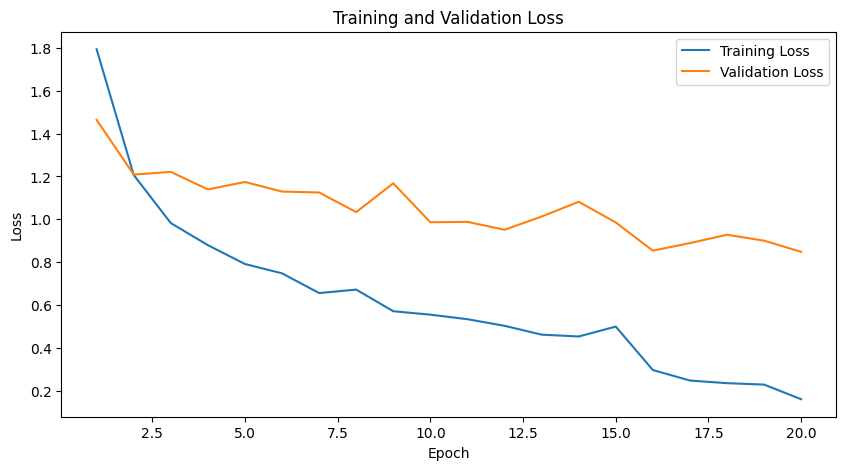

In [28]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist,label="Training Loss")
plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_curve_v3.png")
plt.show()


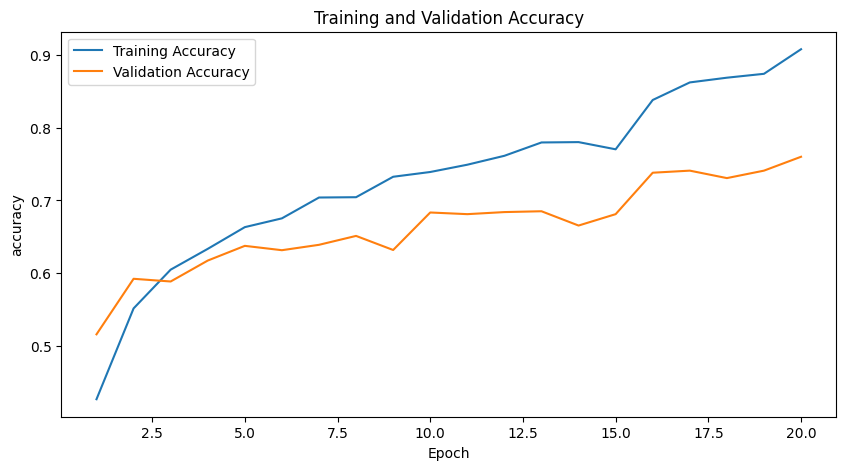

In [29]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_hist) + 1), train_acc_hist,label="Training Accuracy")
plt.plot(range(1, len(val_acc_hist) + 1), val_acc_hist,label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig("accuracy_curve_v3.png")
plt.show()

writer.close()